### 질의 응답 종류
- QA : 질의 응답
- 추출적(extractive) QA : 질문에 대하여 측정 문서를 추출.
- 커뮤니티(community) QA : 포럼의 질문과 응답 데이터를 이용.
- 긴 폼의(long-form) QA : 개방형 질문(단순한)에 대한 응답.
- 테이블(table) QA : 테이블 데이터에 대한 질의 응답.

### 제품 리뷰에 대한 QA 시스템 구축(SubjQA 데이터 셋)

- SubjQA dataset : trip advisor, 음식점, 영화, 책, 전자 제품, 식료품 데이터 

In [1]:
from datasets import get_dataset_config_names # 데이터셋 의 서브 데이터 셋의 이름 확인
from datasets import load_dataset # 데이터셋 의 서브 데이터 셋의 이름 확인

domains = get_dataset_config_names("subjqa")
subjqa_electronics = load_dataset("subjqa", name=domains[1])

In [2]:
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
subjqa_electronics

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

- df 전처리

In [4]:
import pandas as pd

sub_elec_train = subjqa_electronics["train"].to_pandas()
cols_pic = ["title", "question", "answers", "context"]

sub_elec_train = sub_elec_train.loc[:,cols_pic]
sub_elec_train.set_index(keys="title", inplace=True)

sub_elec_train["answers.text"] = [i["text"] for i in sub_elec_train["answers"]]
sub_elec_train["answers.answer_start"] = [i["answer_start"] for i in sub_elec_train["answers"]]
sub_elec_train.drop(columns=["answers"], inplace=True)

In [5]:
sub_elec_train.sample(2, random_state=7)

,question,context,answers.text,answers.answer_start
title,,,,
B005DKZTMG,Does the keyboard lightweight?,I really like this keyboard. I give it 4 star...,[this keyboard is compact],[215]
B00AAIPT76,How is the battery?,I bought this after the first spare gopro batt...,[],[]


In [6]:
# 질문에 자주 쓰이는 단어 확인하기

counts = {}
how_q = ["what", "how", "is", "does", "was", "where", "why"]
for h in how_q:
    inst_count = 0
    for q in sub_elec_train["question"]:
        if h in q.lower().split(" ")[0]:
            inst_count += 1
    counts[h] = inst_count

In [7]:
import pandas as pd

counts = pd.Series(counts).sort_values(ascending=False)

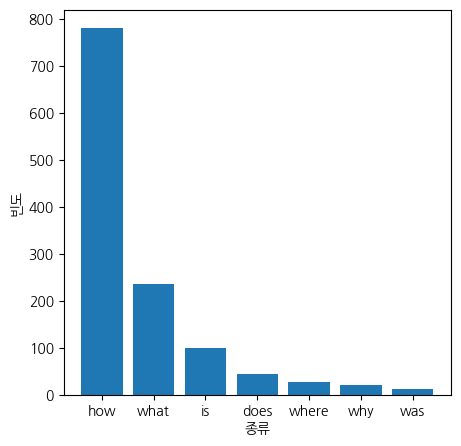

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

ax.bar(counts.index,counts.values)
ax.set_xlabel("종류")
ax.set_ylabel("빈도");

### 질문에 대하여 문맥안에서 정답 문장 추출하기

- question :is this waterproof? 
- context : this watch is waterproof at 30m depth
- 모델 예측 : waterproof at 30m depth
>처리 해야 할 사항
>- 지도 학습 문제로 구성
>- QA 테스크를 위한 토큰화 인코딩
>- 긴텍스트 다루기

>squad(Stanford Question Answering Dataset) 형식
>   - 질문, 리뷰, 답변 형태의 데이터셋
>   - SQuAD 형태의 데이터셋으로 튜닝된 모델을 이용한다.

In [9]:
from transformers import AutoTokenizer
import pandas as pd

tokenizer = AutoTokenizer.from_pretrained("deepset/minilm-uncased-squad2")

question = "how much is it? if i use credit card?"
context = "this surfboard is 699 USD, if you pay for it by credit card, it will be 599 usd"
input = tokenizer(question, context, return_tensors="pt")
words = [tokenizer.decode(t) for t in input["input_ids"][0]]
pd.DataFrame(data=[[int(j) for j in i.flatten()] for i in input.values()],
             columns=words,
             index=input.keys())

,[CLS],how,much,is,it,?,if,i,use,credit,...,credit,card,",",it,will,be,59,##9,usd,[SEP]
input_ids,101,2129,2172,2003,2009,1029,2065,1045,2224,4923,...,4923,4003,1010,2009,2097,2022,5354,2683,13751,102
token_type_ids,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [10]:
import torch
from transformers import AutoModelForQuestionAnswering

minilm = AutoModelForQuestionAnswering.from_pretrained("deepset/minilm-uncased-squad2")
print("-"*50)
with torch.no_grad():
    output = minilm(**input)
    # logit 값출력 이 출력값은 input 값의 context의 시작과 끝의 확률값을 나타낸다.

2024-12-11 20:37:54.738045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733917074.870359    1044 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733917074.909638    1044 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 20:37:55.234257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswerin

--------------------------------------------------


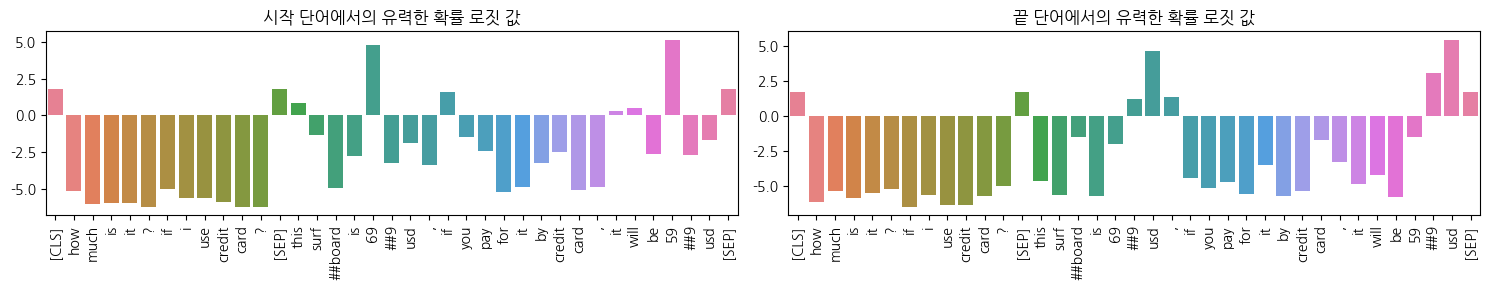

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1,2,figsize=(15,3))

sns.barplot(output.start_logits,ax = axes[0])
sns.barplot(output.end_logits,ax = axes[1])

axes[0].set_xticks(range(len(words)))
axes[0].set_xticklabels(words, rotation="vertical")  # 레이블 설정 및 회전
axes[0].set_title("시작 단어에서의 유력한 확률 로짓 값")

axes[1].set_xticks(range(len(words)))
axes[1].set_xticklabels(words, rotation="vertical")  # 레이블 설정 및 회전
axes[1].set_title("끝 단어에서의 유력한 확률 로짓 값")

fig.set_tight_layout(True)

In [12]:
import torch

start_idx = torch.argmax(output.start_logits)
end_idx = torch.argmax(output.end_logits) + 1

print("질문 :", question)
print("대답 :", tokenizer.decode(input["input_ids"][0][start_idx:end_idx])) # 예측값 : 시작 단어 인덱스 ~ 끝 단어 인덱스

질문 : how much is it? if i use credit card?
대답 : 599 usd


In [13]:
# 위의 과정을 한번에 pipeline 으로 실행시키기
from transformers import pipeline

minilm = AutoModelForQuestionAnswering.from_pretrained("deepset/minilm-uncased-squad2")
tokenizer = AutoTokenizer.from_pretrained("deepset/minilm-uncased-squad2")

qa_pipe = pipeline("question-answering", model = minilm, tokenizer = tokenizer, device=0)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
question = "how much is it? if i use credit card?"
question_2 = "how much is it?"
question_3 = "who am i talking to?"
context = "this surfboard is 699 usd, if you pay for it by credit card, it will be 599 usd"


print(f"""\
q1 : {question}
q2 : {question_2}
answer : {context}

predict :
q1 : {qa_pipe(question=question,context=context)["answer"]}
    score : {qa_pipe(question=question,context=context)["score"]:0.2f}
q2 : {qa_pipe(question=question_2,context=context)["answer"]}
    score : {qa_pipe(question=question_2,context=context)["score"]:0.2f}

{"-"*20}top_k 파라미터 in q1{"-"*49}
top 1 : {qa_pipe(question=question,context=context, top_k=3)[0]}
top 2 : {qa_pipe(question=question,context=context, top_k=3)[1]}
top 3 : {qa_pipe(question=question,context=context, top_k=3)[2]}

여기서 score 는 logit 값에 softmax 함수를 취한 값
{"-"*87}
handle_impossible_answer 를 이용하면 질문의 답이 없을 경우도 취급한다. {"-"*27}
질문 : {question_3}
{qa_pipe(question=question_3,context=context, handle_impossible_answer=True)}
{"-"*87}\
""")


q1 : how much is it? if i use credit card?
q2 : how much is it?
answer : this surfboard is 699 usd, if you pay for it by credit card, it will be 599 usd

predict :
q1 : 599 usd
    score : 0.35
q2 : 699 usd
    score : 0.88

--------------------top_k 파라미터 in q1-------------------------------------------------
top 1 : {'score': 0.34522750973701477, 'start': 72, 'end': 79, 'answer': '599 usd'}
top 2 : {'score': 0.1093478873372078, 'start': 18, 'end': 25, 'answer': '699 usd'}
top 3 : {'score': 0.03263687714934349, 'start': 72, 'end': 75, 'answer': '599'}

여기서 score 는 logit 값에 softmax 함수를 취한 값
---------------------------------------------------------------------------------------
handle_impossible_answer 를 이용하면 질문의 답이 없을 경우도 취급한다. ---------------------------
질문 : who am i talking to?
{'score': 0.9818470478057861, 'start': 0, 'end': 0, 'answer': ''}
---------------------------------------------------------------------------------------


### 긴 문장 다루기

- sliding window 이용
- transformer 에서 `return_overflowing_tokens=True` 설정
- context 의 모든 경우의 수를 따져가며 모델출력을 낼 수 있다 (토큰 길이가 너무 길경우에 잘리는 경우가 없다.)

In [15]:
tokenizer_example=tokenizer(sub_elec_train.iloc[0]["question"],
                            sub_elec_train.iloc[0]["context"],
                            stride=30,
                            max_length=60,
                            return_overflowing_tokens=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [16]:
# 각 입력에 대한 대답들의 windows 들
print("전체 문장 : stride 만큼 이동하며 출력을 만듦")
print(sub_elec_train.iloc[0]["question"])
print(sub_elec_train.iloc[0]["context"],end="\n\n")
for i in tokenizer_example["input_ids"]:
    print(tokenizer.decode(i))

전체 문장 : stride 만큼 이동하며 출력을 만듦
How is the bass?
I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in [SEP]
[CLS] how is the bass? [SEP]ss portapro is portable and has great bass response. the work great with my a

### HayStack 일 이용한 pipeline 구축
![pipeline](images/07_01.png)

- Retriever
    - sparce retriever : **TD-IDF** 와 같이 단어의 빈도수 기반으로 **희소 벡터**로 표현 <br>
        [0,1,0,0]...
    - dense retriever : 트랜스 포머와 같은 인코더를 이용해 **밀집 벡터**로 표현 <br>
        [0.2,0.3,0,6]...
- Reader
    - 리트리버가 제공한 문서에서 답추출 (독해모델이 대부분, but 자유 형식 가능)

- document store
    - 리트리버 제공문서와 메타데이터 저장

- pipeline
    - 리트리버, 리더, 데이터베이스 등을 조합하여 하나의 연속적인 작업 흐름을 구성.

### Document Store (Vector Store)
[RAG 의 vectorstore 참조](https://github.com/tommyjin2894/ai_study_LangChain_with_RAG/blob/main/6_vector_store.ipynb)

|방식|메모리|Elasticsearch|FAISS|Milvus|
|:---:|:---:|:---:|:---:|:---:|
|TF-IDF| Y | Y | N | N |
|BM25| N | Y | N | N |
|Embedding| Y | Y | Y | Y |
|DPR| Y | Y | Y | Y |

- 여기서 Elasticsearch 는 모든 형식(방식)의 저장소 형태에서 저장 가능

<br>

> cf vector store : 문서를 벡터화 하여 검색시 유사도 계산 <br>
> FAISS, Elasticsearch 는 vector store 로도 사용 될 수 있다.

### elastic search 설치하기

[install guide](https://www.elastic.co/guide/en/elasticsearch/reference/current/targz.html)

- 설치하기 및 실행
  
  ```bash
  wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.16.1-linux-x86_64.tar.gz
  wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.16.1-linux-x86_64.tar.gz.sha512
  shasum -a 512 -c elasticsearch-8.16.1-linux-x86_64.tar.gz.sha512 
  tar -xzf elasticsearch-8.16.1-linux-x86_64.tar.gz
  cd elasticsearch-8.16.1/
  
  ./bin/elasticsearch
  ```
- 비밀번호 리셋
  ```bash
  ./bin/elasticsearch-reset-password -u elastic
  ```

- api 키 발급 받기

  ```bash
  curl -u "elastic:<password>" -X POST "https://localhost:9200/_security/api_key" -H "Content-Type: application/json" -d '{
    "name": "my_api_key",
    "role_descriptors": {
      "my_custom_role": {
        "cluster": ["all"],
        "index": [
          {
            "names": ["*"],
            "privileges": ["read", "write"]
          }
        ]
      }
    }
  }'
  ```

In [34]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(
    hosts="https://localhost:9200"
)

In [35]:
import pandas as pd

sub_elec_all = {}
for split in subjqa_electronics:
    sub_elec_inst = subjqa_electronics[split].to_pandas()
    cols_pic = ["title", "question", "answers", "context","id"]

    sub_elec_inst = sub_elec_inst.loc[:,cols_pic]
    sub_elec_inst["answers.text"] = [i["text"] for i in sub_elec_inst["answers"]]
    sub_elec_inst["answers.answer_start"] = [i["answer_start"] for i in sub_elec_inst["answers"]]
    sub_elec_inst.drop(columns=["answers"], inplace=True)
    sub_elec_all[split]=sub_elec_inst

In [36]:
from haystack import Document

for split, df in sub_elec_all.items():
    docs = []
    for idx_name, row in df.drop_duplicates(subset="context").iterrows():
        doc_ = Document(
            id = row.context,
            meta = {"item_id":row["title"],
                    "question_id":row["id"],
                    "split":split}
        )
        docs.append(doc_)
    document_store.write_documents(docs)

TlsError: TLS error caused by: TlsError(TLS error caused by: SSLError([SSL] record layer failure (_ssl.c:1006)))

In [38]:
!curl -X GET "http://localhost:9200/_cluster/health?pretty"

curl: (7) Failed to connect to localhost port 9200 after 0 ms: Could not connect to server
